In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

from collections import defaultdict
from tqdm.notebook import tqdm

In [2]:
rng = np.random.default_rng(42)

In [3]:
# Ground truths
N = 11
p = np.linspace(.05, .15, N)

In [4]:
class EpsilonGreedyPolicy:
    def __init__(self, rng=rng, N=N, epsilon=0.0, alpha0=0, beta0=0):
        self.rng=rng
        self.epsilon=epsilon
        self.alpha0=alpha0
        self.beta0=beta0
        
        self.S = np.zeros(N)
        self.F = np.zeros(N)
    
    def act(self):
        if self.rng.random() > self.epsilon:
            p_hat = np.zeros_like(self.S)
            nonzero_mask = np.where((self.S+self.alpha0+self.F+self.beta0)>0)
            p_hat[nonzero_mask] = (self.alpha0+self.S[nonzero_mask]) / \
                (self.alpha0+self.S[nonzero_mask]+self.beta0+self.F[nonzero_mask])
            return np.random.choice(np.flatnonzero(p_hat == p_hat.max()))
        else:
            return np.random.choice(len(self.S))
        
    def update(self, a, r):
        if r:
            self.S[a] += 1
        else:
            self.F[a] += 1
            
    def reset(self):
        self.S = np.zeros(N)
        self.F = np.zeros(N)

class UCBPolicy:
    def __init__(self, rng=rng, N=N, alpha0=1, beta0=1, q=0.7):
        self.rng=rng
        self.alpha0=alpha0
        self.beta0=beta0
        self.q=q
        
        self.S = np.zeros(N)
        self.F = np.zeros(N)
    
    def act(self):
        p_hat = scipy.stats.beta.ppf(self.q, self.alpha0+self.S, self.beta0+self.F)        
        return np.random.choice(np.flatnonzero(p_hat == p_hat.max()))
        
    def update(self, a, r):
        if r:
            self.S[a] += 1
        else:
            self.F[a] += 1
            
    def reset(self):
        self.S = np.zeros(N)
        self.F = np.zeros(N)
            
class ThompsonSamplingPolicy:
    def __init__(self, rng=rng, N=N, alpha0=1, beta0=1):
        self.rng=rng
        self.alpha0=alpha0
        self.beta0=beta0
        
        self.S = np.zeros(N)
        self.F = np.zeros(N)
    
    def act(self):
        p_hat = self.rng.beta(self.alpha0+self.S, self.beta0+self.F)        
        return np.random.choice(np.flatnonzero(p_hat == p_hat.max()))
        
    def update(self, a, r):
        if r:
            self.S[a] += 1
        else:
            self.F[a] += 1
            
    def reset(self):
        self.S = np.zeros(N)
        self.F = np.zeros(N)
            
            
class OraclePolicy:
    def __init__(self, p):
        self.p = p
    
    def act(self):
        return np.argmax(p)
    
    def update(self, a, r):
        pass
    
    def reset(self):
        pass

In [5]:
policies = {
    'MLE-Greedy': EpsilonGreedyPolicy(rng, N=N, epsilon=0.0, alpha0=0, beta0=0),
    'MAP-Greedy': EpsilonGreedyPolicy(rng, N=N, epsilon=0.0, alpha0=2, beta0=10),
   r'$\epsilon$-Greedy': EpsilonGreedyPolicy(rng, N=N, epsilon=0.05, alpha0=2, beta0=10),
    'Thompson': ThompsonSamplingPolicy(rng, N=N, alpha0=2, beta0=10),
    'UCB': UCBPolicy(rng, N=N, alpha0=2, beta0=10, q=0.7),
    'Oracle': OraclePolicy(p),
}

In [6]:
def simulate_round(policies, pool_data=True):
    # Placeholder for data with which we update after this round
    updates = []
    
    # Placeholder for metric per policy
    rewards = []
    
    # Give a sample to every policy
    for policy_name, policy in policies.items():        
        # Act
        a = policy.act()
        if policy_name != 'Oracle':
            # Simulate reward
            r = rng.random() < p[a]
            # Store sample to update later and pooled            
            if pool_data:
                updates.append((a, r))
            else:
                policy.update(a, r)
        
        # Store E[reward] instead of sampled reward for reduced variance
        rewards.append(p[a])
        
    # Update every policy
    if pool_data:
        for policy_name, policy in policies.items():
            for a, r in updates:
                policy.update(a, r)
    
    return rewards

def simulate_run(policies, pool_data=True):
    policy2rewards = defaultdict(list)
    for _ in tqdm(range(2_000_000)):        
        for y, p in zip(simulate_round(policies, pool_data), policies.keys()):
            policy2rewards[p].append(y)
    
    for policy in policies.values():
        policy.reset()
            
    return policy2rewards

## Pooled Data results

In [7]:
num_runs = 20
run2policy2reward_pooled = {}
for run in tqdm(range(num_runs)):
    run2policy2reward_pooled[run] = simulate_run(policies, pool_data=True)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:01<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

In [8]:
policy2reward_pooled_mean = {
    policy_name: np.vstack([np.cumsum(run2policy2reward_pooled[i][policy_name]) for i in range(num_runs)]).mean(axis=0)
    for policy_name in policies.keys()
}
policy2reward_pooled_std = {
    policy_name: np.vstack([np.cumsum(run2policy2reward_pooled[i][policy_name]) for i in range(num_runs)]).std(axis=0)
    for policy_name in policies.keys()
}

## Non-pooled Data results

In [9]:
run2policy2reward_siloed = {}
for run in tqdm(range(num_runs)):
    run2policy2reward_siloed [run] = simulate_run(policies, pool_data=False)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:13<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

In [10]:
policy2reward_siloed_mean = {
    policy_name: np.vstack([np.cumsum(run2policy2reward_siloed[i][policy_name]) for i in range(num_runs)]).mean(axis=0)
    for policy_name in policies.keys()
}
policy2reward_siloed_std = {
    policy_name: np.vstack([np.cumsum(run2policy2reward_siloed[i][policy_name]) for i in range(num_runs)]).std(axis=0)
    for policy_name in policies.keys()
}

## Visualise

In [11]:
import matplotlib as mpl

new_rc_params = {'text.usetex': True,
    'svg.fonttype': 'none',
    'font.family': 'Linux Libertine',
    'text.latex.preamble': r'\usepackage{libertine}',
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'libertine',
    'mathtext.it': 'libertine:italic',
    'mathtext.bf': 'libertine:bold'
    }
mpl.rcParams.update(new_rc_params)
plt.style.use('tableau-colorblind10')
plt.rc('axes', axisbelow=True)

# https://gist.github.com/AndiH/c957b4d769e628f506bd
# Tableau 20 Colors
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Tableau Color Blind 10
tableau20blind = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]
  
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)
for i in range(len(tableau20blind)):  
    r, g, b = tableau20blind[i]  
    tableau20blind[i] = (r / 255., g / 255., b / 255.)
    
linestyles=['-', '--', (0, (5, 10)), '-.', ':']

In [12]:
figsize=(10,2.25)
fontsize=16

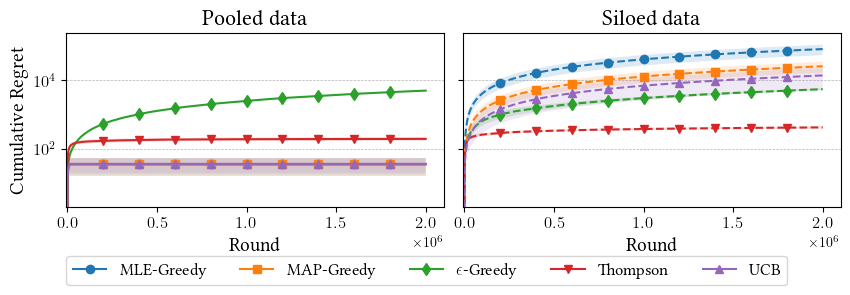

In [19]:
fig, axes = plt.subplots(1, 2, sharey='row', figsize=figsize,gridspec_kw={'width_ratios': [1, 1], 'wspace': .05})
cycler = plt.cycler(
    color=tableau20[0:10:2],
    marker=['o','s','d','v','^']
)
axes[0].set_prop_cycle(cycler)
axes[1].set_prop_cycle(cycler)

for policy, reward in policy2reward_pooled_mean.items():    
    if policy != 'Oracle':
        # Pooled Data
        y = policy2reward_pooled_mean['Oracle'] - policy2reward_pooled_mean[policy]
        x = np.arange(len(y))
        jump=100
        
        axes[0].plot(x[::jump], y[::jump], label=f'{policy}', markevery=2000)

        y_lo = y - 1.96 * policy2reward_pooled_std[policy] / np.sqrt(num_runs)
        y_hi = y + 1.96 * policy2reward_pooled_std[policy] / np.sqrt(num_runs)
        axes[0].fill_between(x[::jump], y_lo[::jump], y_hi[::jump], alpha=0.15)
        
        # Siloed Data
        y = policy2reward_siloed_mean['Oracle'] - policy2reward_siloed_mean[policy]
        axes[1].plot(x[::jump], y[::jump], ls='--', label=f'{policy} (siloed)', markevery=2000)

        y_lo = y - 1.96 * policy2reward_siloed_std[policy] / np.sqrt(num_runs)
        y_hi = y + 1.96 * policy2reward_siloed_std[policy] / np.sqrt(num_runs)
        axes[1].fill_between(x[::jump], y_lo[::jump], y_hi[::jump], alpha=0.15)

plt.yscale('log')
plt.ylim(2, None)

axes[0].set_xlim(-10_000, None)
axes[1].set_xlim(-10_000, None)

axes[0].set_title('Pooled data', fontsize=fontsize)
axes[1].set_title('Siloed data', fontsize=fontsize)

axes[0].grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
axes[0].set_xlabel('Round', fontsize=fontsize-2)
axes[0].set_ylabel('Cumulative Regret', fontsize=fontsize-2)
axes[0].tick_params(labelsize=fontsize-4)
axes[0].legend(fontsize=fontsize-4, ncols=5, loc='lower left', bbox_to_anchor=(-0.02, -.5))
axes[1].grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
axes[1].set_xlabel('Round', fontsize=fontsize-2)
axes[1].tick_params(labelsize=fontsize-4)

plt.savefig('Fig1.pdf', transparent=True, bbox_inches='tight')
plt.show()